# SEG Bootcamp - first-look data analysis for source signature data

This notebook contains basic data visualization and analysis of the data collected with Stryde nodes at KAUST during the SEG Student Chapter bootcamp on Nov 7 2023.

The dataset is acquired as follows:

- <font color='blue'>Receivers</font>

    1 line of 89 buried receivers, equally spaced by 2m for a total lenght of 178m.

    1 receiver placed near (and following) the source  (this is the last of each shot gather)

- <font color='red'>Sources</font>

    9 sources on the right side of the receiver line at Point 2001, 2010, 2019, 2028, 2037, 2046, 2055, 2064, 2073, 2082 (18m distance)

    10 shots per source

In [106]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pylops
import matplotlib.pyplot as plt

from matplotlib.colors import SymLogNorm
from pylops.signalprocessing import FFT2D

from pystryde.reader import *
from pystryde.preproc import *
from pystryde.cmap import cmaps
from pystryde.visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis for shot

In [107]:
# Selected shot
#ishot = 0 
#tlims = (100, 480)

#ishot = 1
#tlims = (20, 600)

ishot = 8 # from 2 to 8
tlims = (200, 600)

#ishot = 9
#tlims = (200, 900)

t0s = [0.335, 0.18, 0.355, 0.34, 0.275, 0.235, 0.264, 0.357, 0.25, 0.405]

Data shape: (10, 1, 10, 90, 6000)


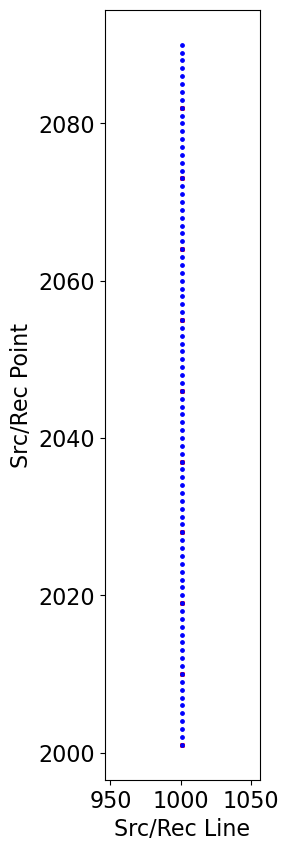

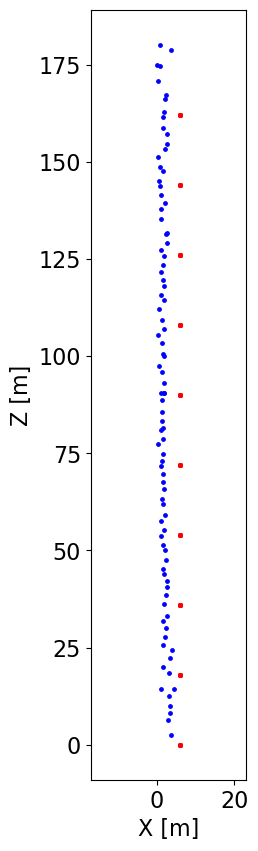

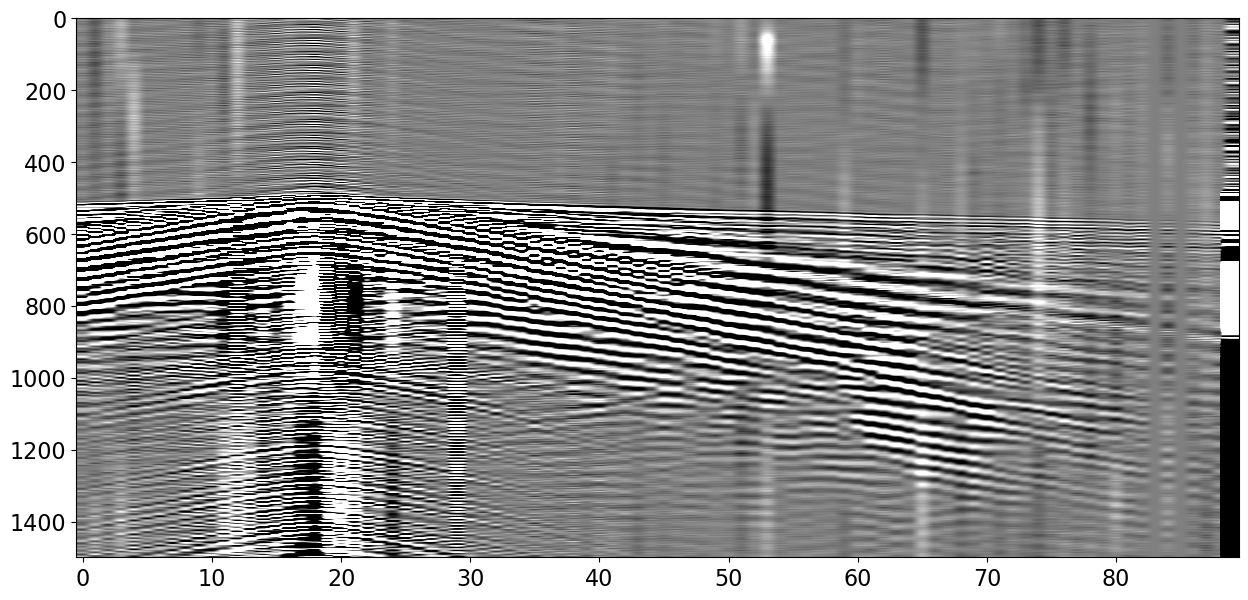

In [108]:
fs = strydeshots('/mnt/datawaha_dig/Data/STRYDE/SEGBootcamp_07_11_2023/ShotGathers_Acc/')
fs.interpret()
fs.getshot()

fs.recx = fs.recx.astype(np.float32)
fs.recy = fs.recy.astype(np.float32)
fs.recx[fs.recx==0] = np.nan
fs.recx[np.isnan(fs.recx)] = np.nanmean(fs.recx)
fs.recy[fs.recy==0] = np.nan
fs.recy[np.isnan(fs.recy)] = np.nanmean(fs.recy)

print('Data shape:', fs.data.shape)

fs.plotgeom(coords=False, figsize=(2, 10))
fig, ax = fs.plotgeom(local=True, figsize=(2, 10))
ax.axis('equal')
plt.savefig('Figs/localsurveygeometry.png', dpi=200)

plt.figure(figsize=(15,7))
plt.imshow(fs.data[ishot, 0, 2, :, :1500].T, cmap='gray', vmin=-1e-3, vmax=1e-3)
plt.axis('tight');

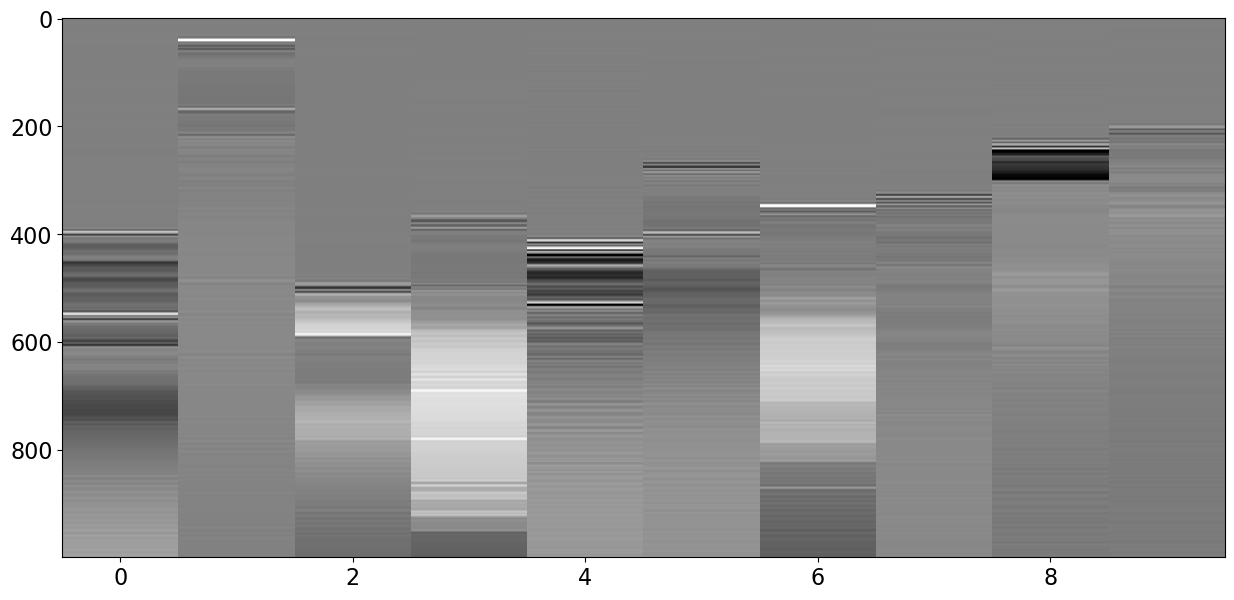

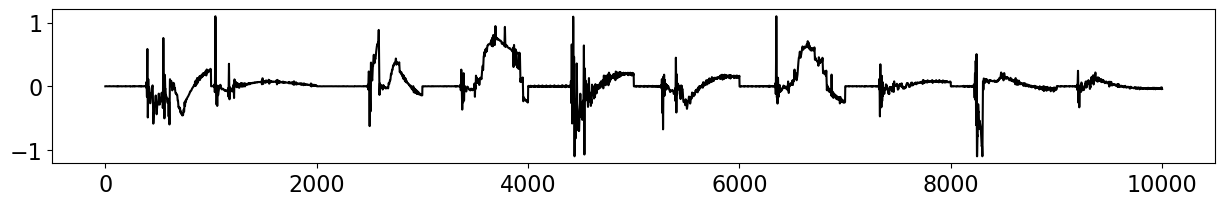

In [109]:
plt.figure(figsize=(15,7))
plt.imshow(fs.data[ishot, 0, :, -1, :1000].T, cmap='gray', interpolation='none', vmin=-1e0, vmax=1e0)
plt.axis('tight');

plt.figure(figsize=(15,2))
plt.plot(fs.data[ishot, 0, :, -1, :1000].ravel(), 'k')


### Improve data alignment via cross-correlation

Let's start with a single shot location. We will use the traces at the closest receiver to find the best alignment

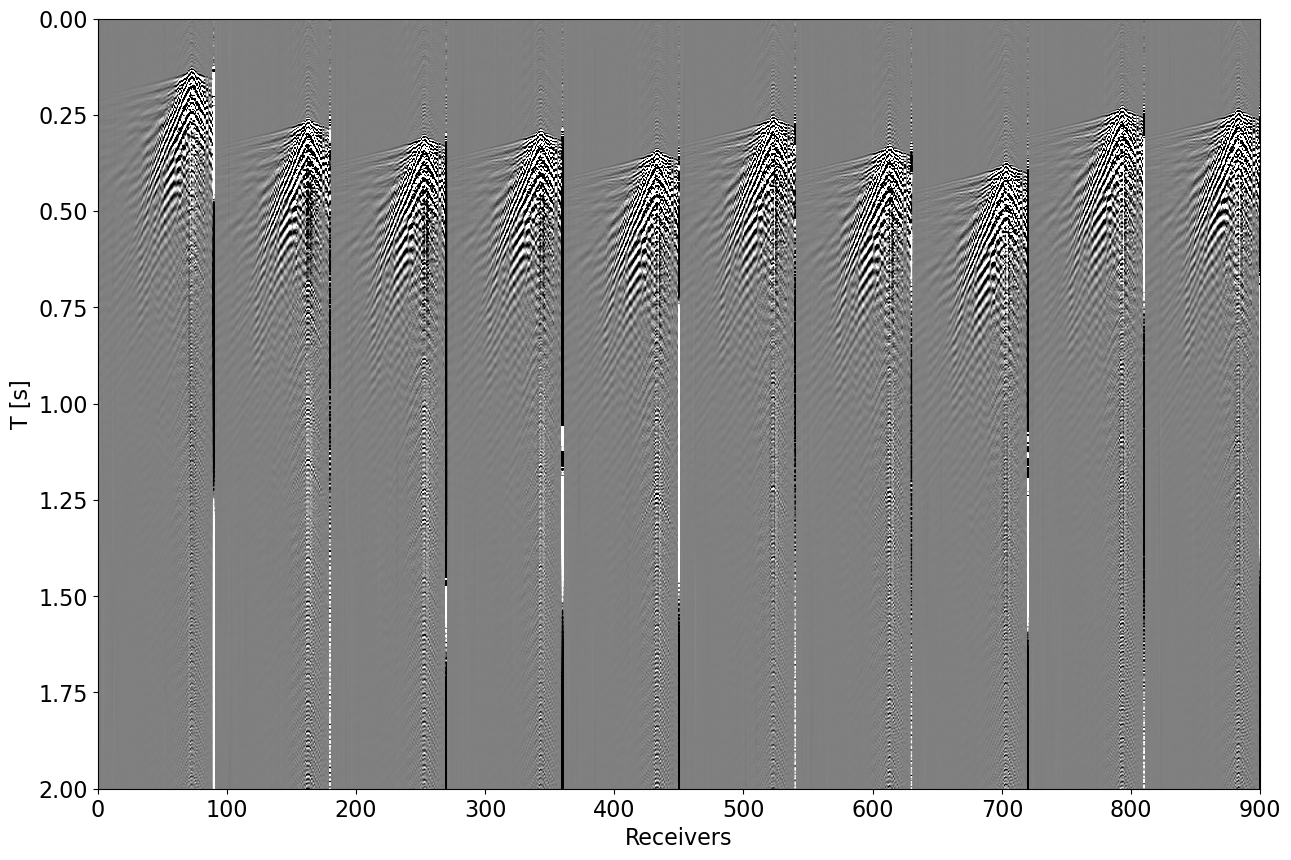

In [110]:
data = fs.data

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(data[:, 0, ishot].reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 90*10, fs.t[-1], 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., 0);

(8, 1, 10, 90, 6000)
Indices of max aligment: [399 354 368 318 404 329 284 429]


Indices of max aligment after shifts: [399 399 399 399 399 399 399 399]


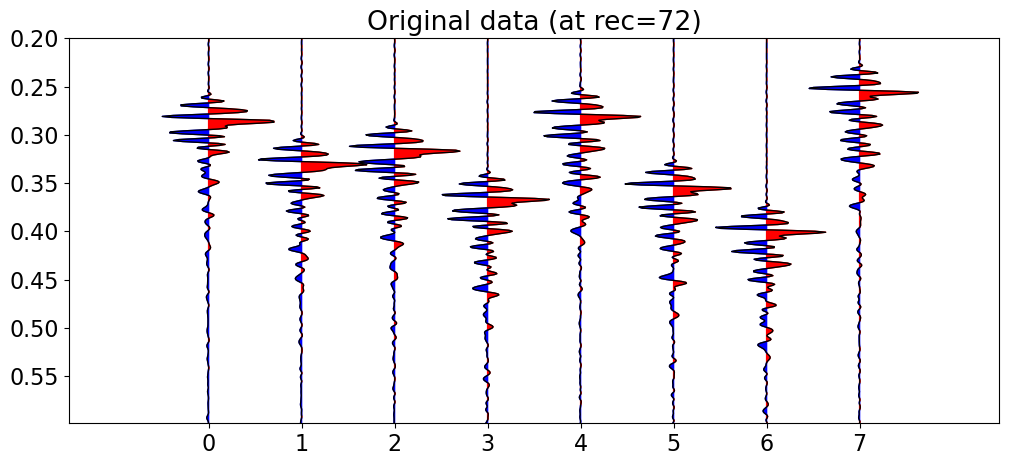

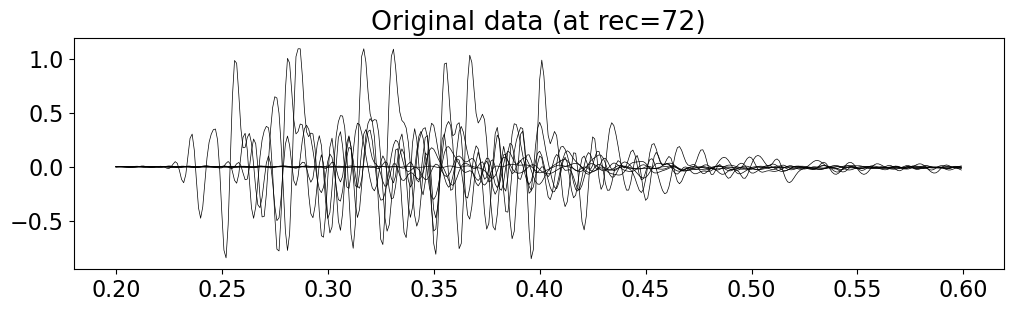

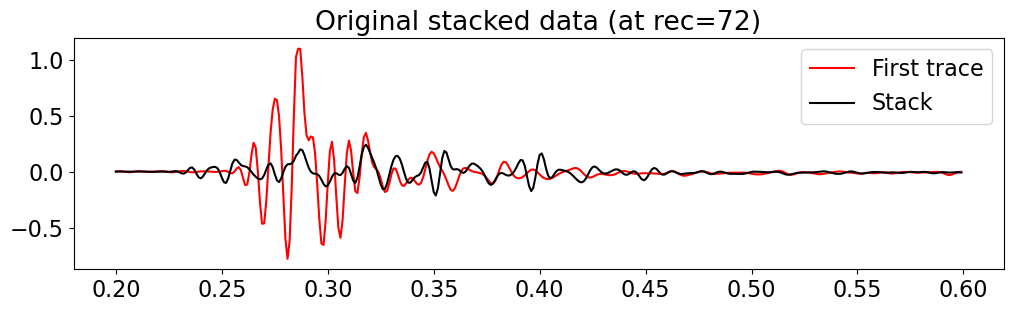

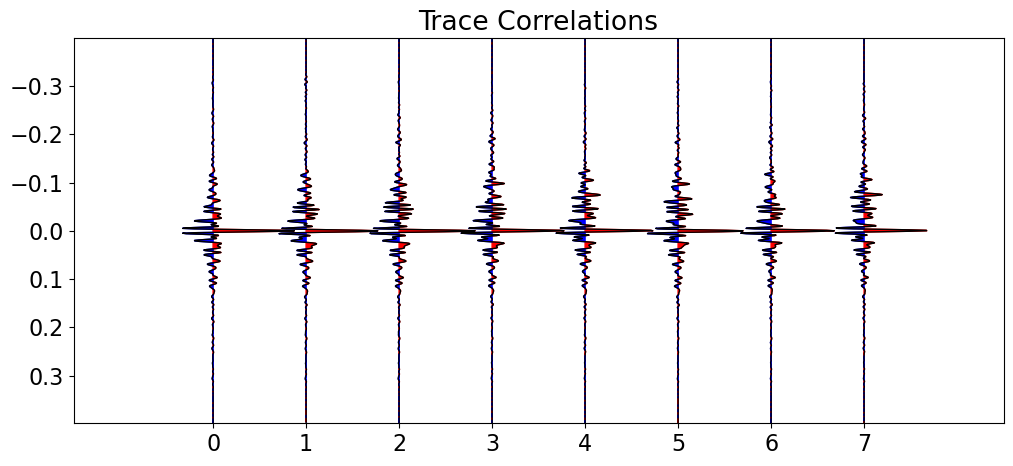

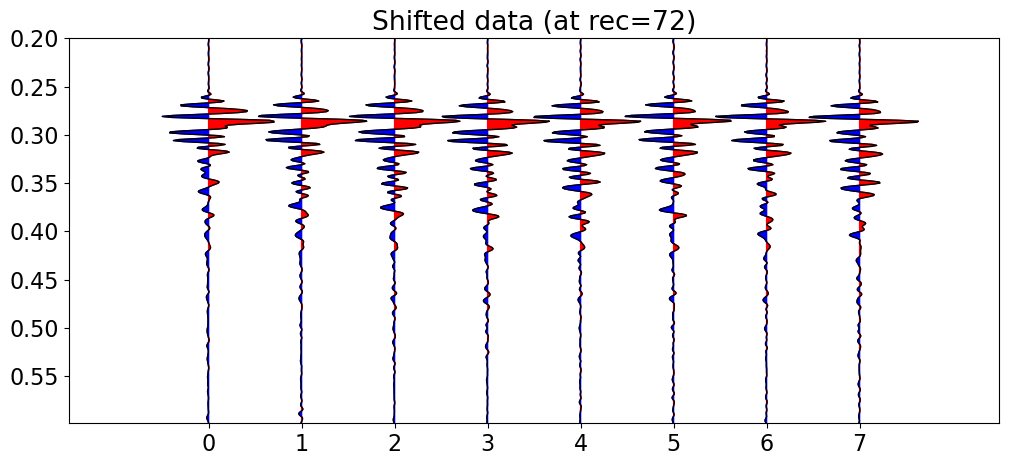

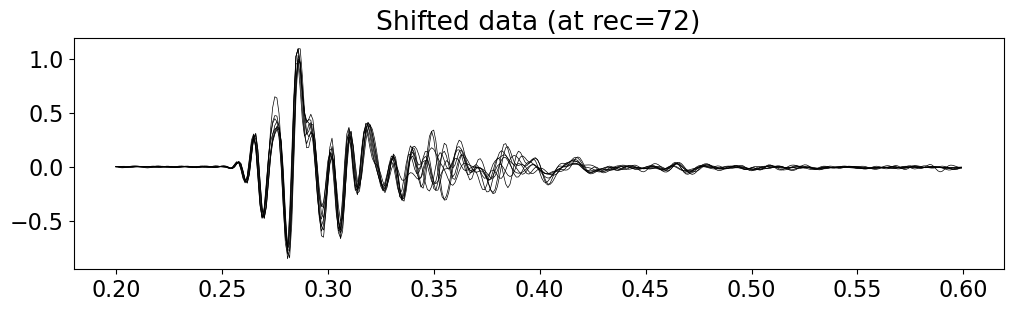

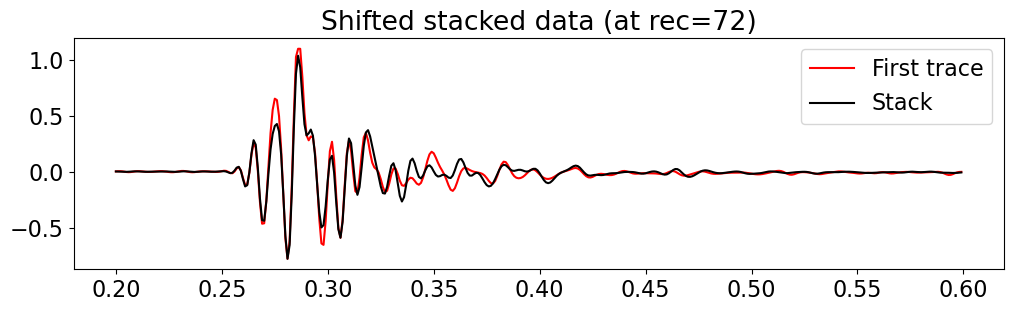

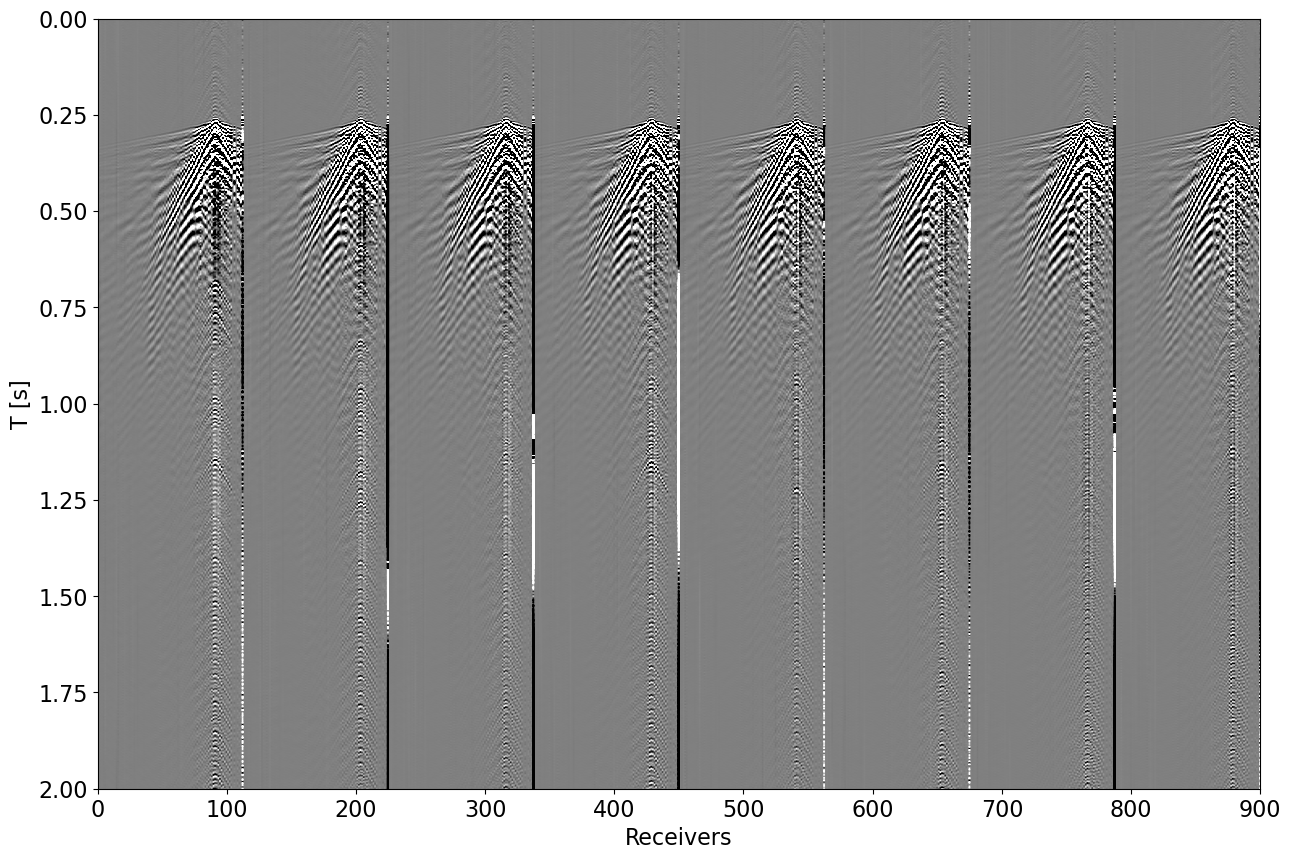

In [111]:
data = fs.data[1:-1]
print(data.shape)
datashift, figs = aligndata(data[:, 0, ishot], np.where(fs.recpoint == fs.srcpoint_axis[ishot])[0][0], fs.t, 
                            tlims=tlims, plotflag=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(datashift.reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 90*10, fs.t[-1], 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., 0);

(210.0, 330.0)

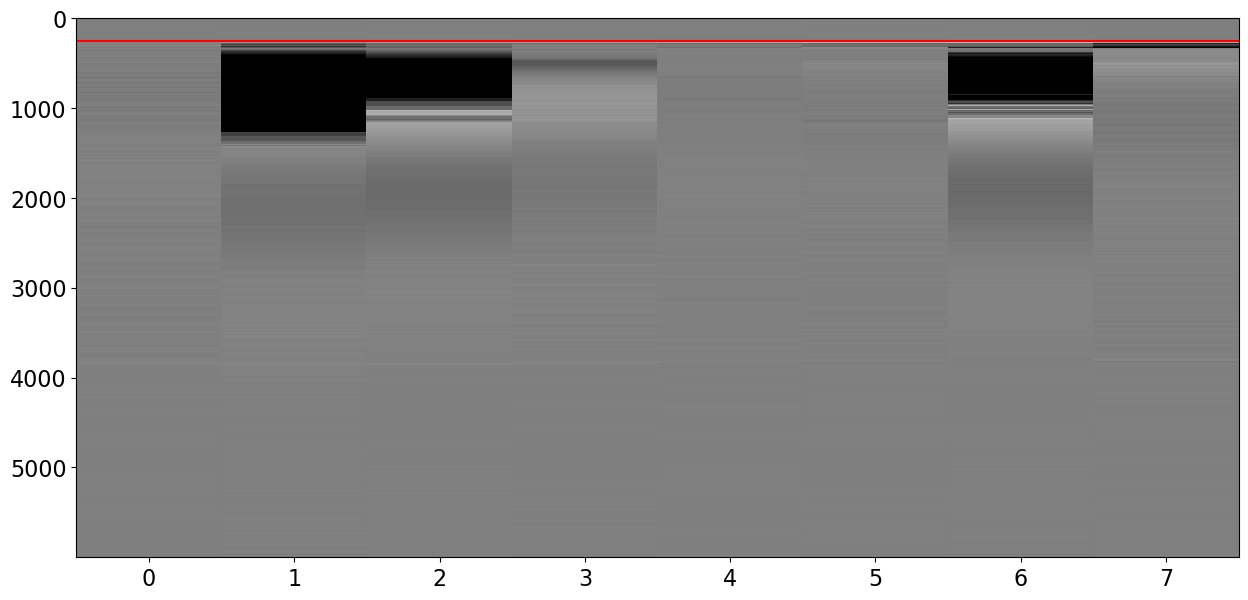

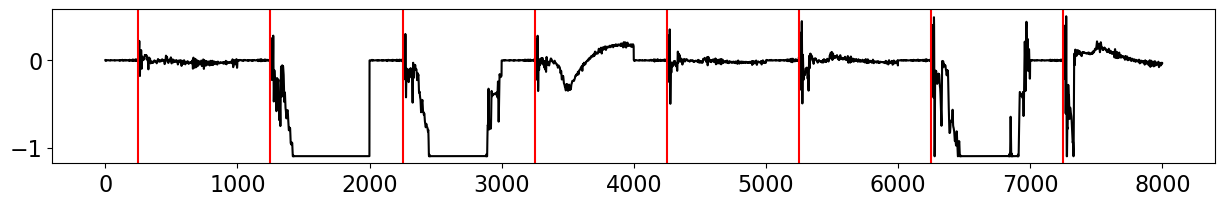

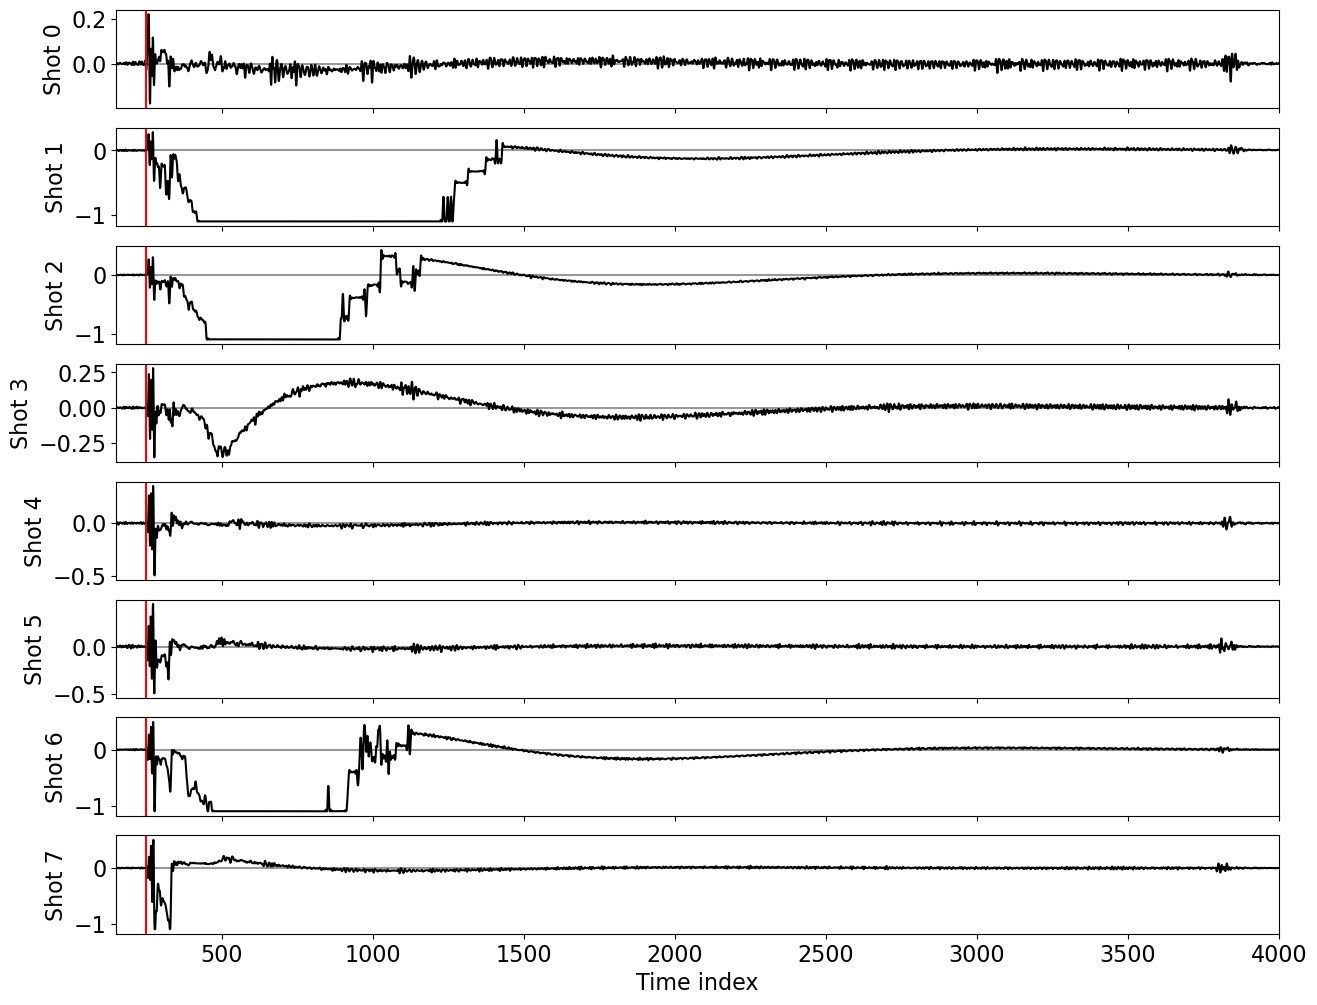

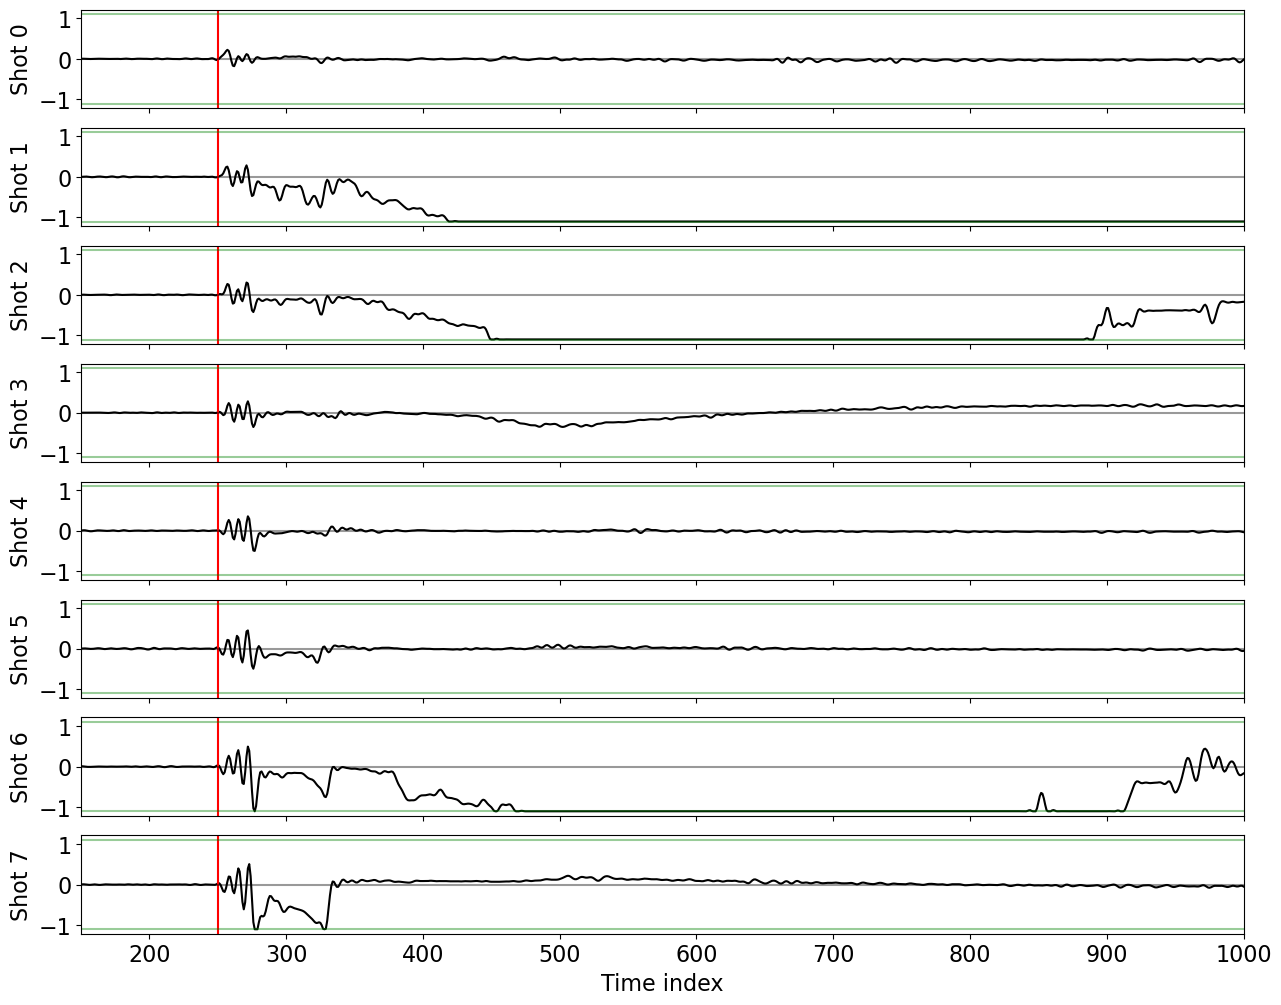

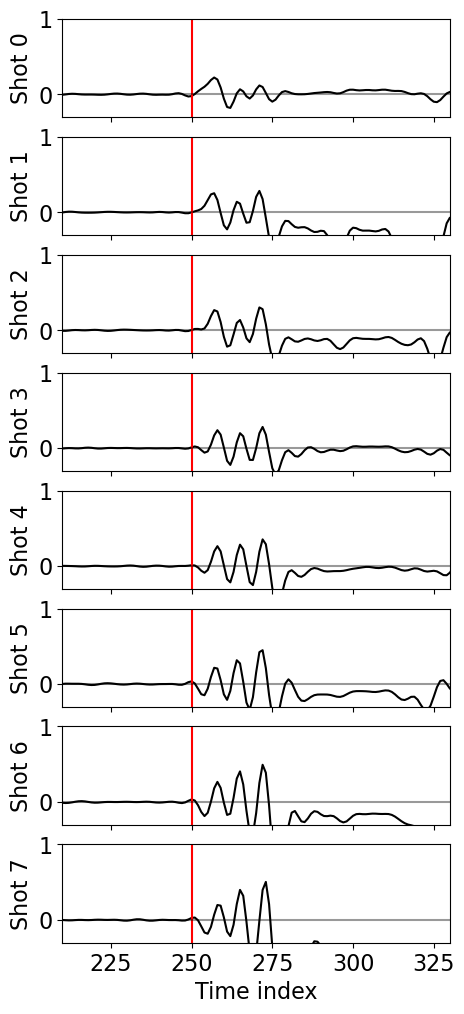

In [112]:
# Find first break of every shot
it0 = int(t0s[ishot] / fs.dt) 

plt.figure(figsize=(15,7))
plt.imshow(datashift[:, -1].T, cmap='gray', interpolation='none', vmin=-1e0, vmax=1e0)
plt.axhline(it0, c='r')
plt.axis('tight')
plt.savefig(f"Figs/shot{ishot}_sourcesig_impng", dpi=200);

plt.figure(figsize=(15,2))
plt.plot(datashift[:, -1, :1000].ravel(), 'k')
for i in range(datashift.shape[0]): 
    plt.axvline(it0 + i * 1000, c='r')
plt.savefig(f"Figs/shot{ishot}_sourcesig_cont.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 4000)
plt.savefig(f"Figs/shot{ishot}_sourcesig.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 1000)
plt.savefig(f"Figs/shot{ishot}_sourcesig_zoom.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(5, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
    axs[i].set_ylim(-0.3, 1.)
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-40, it0+80)


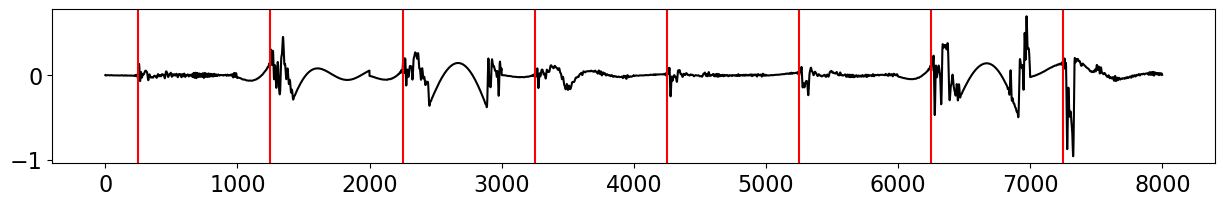

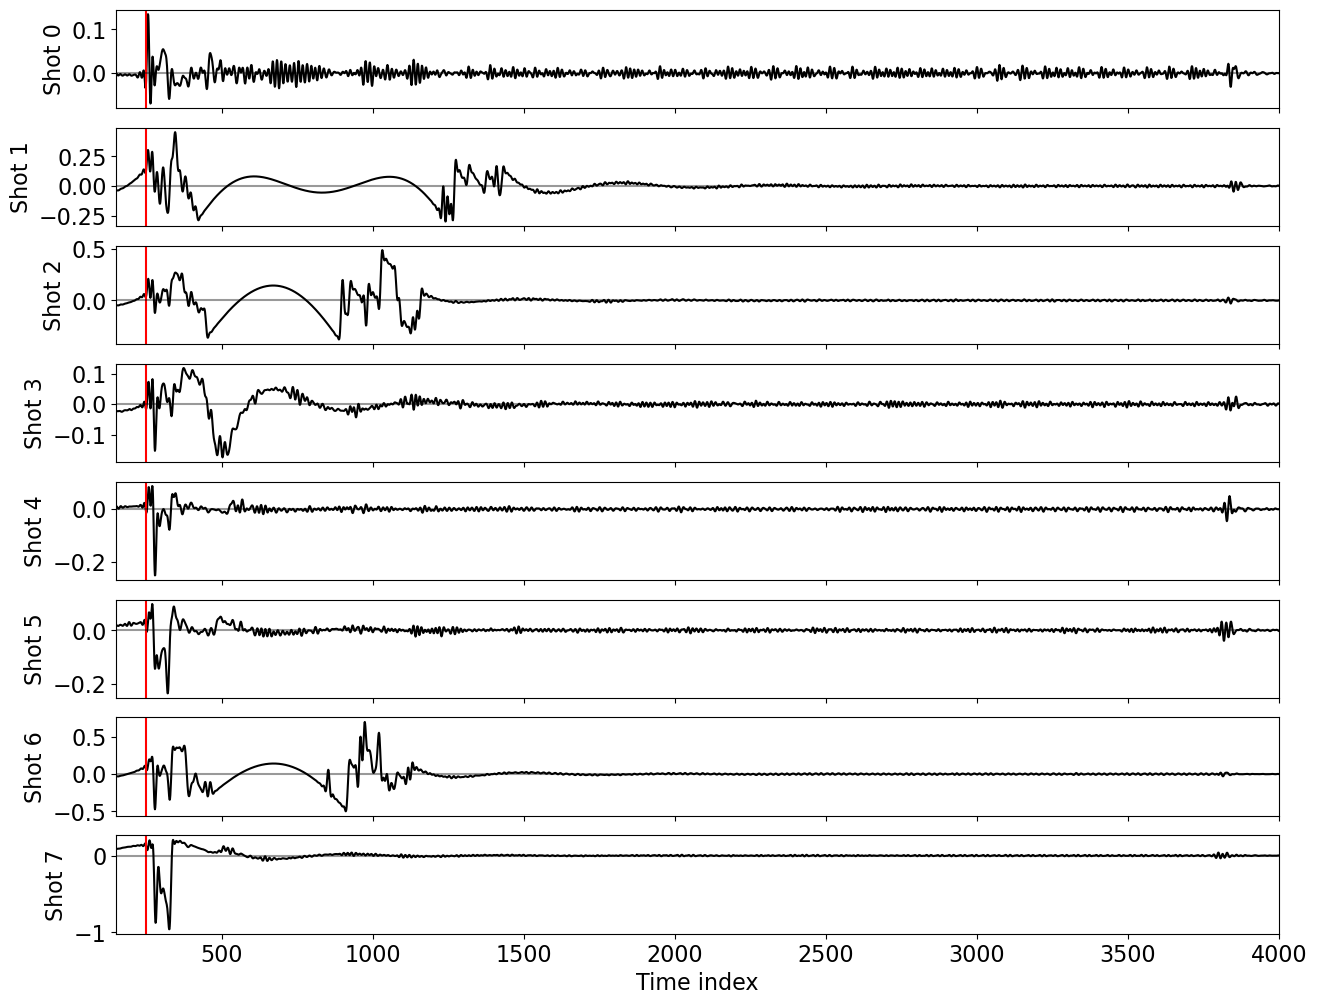

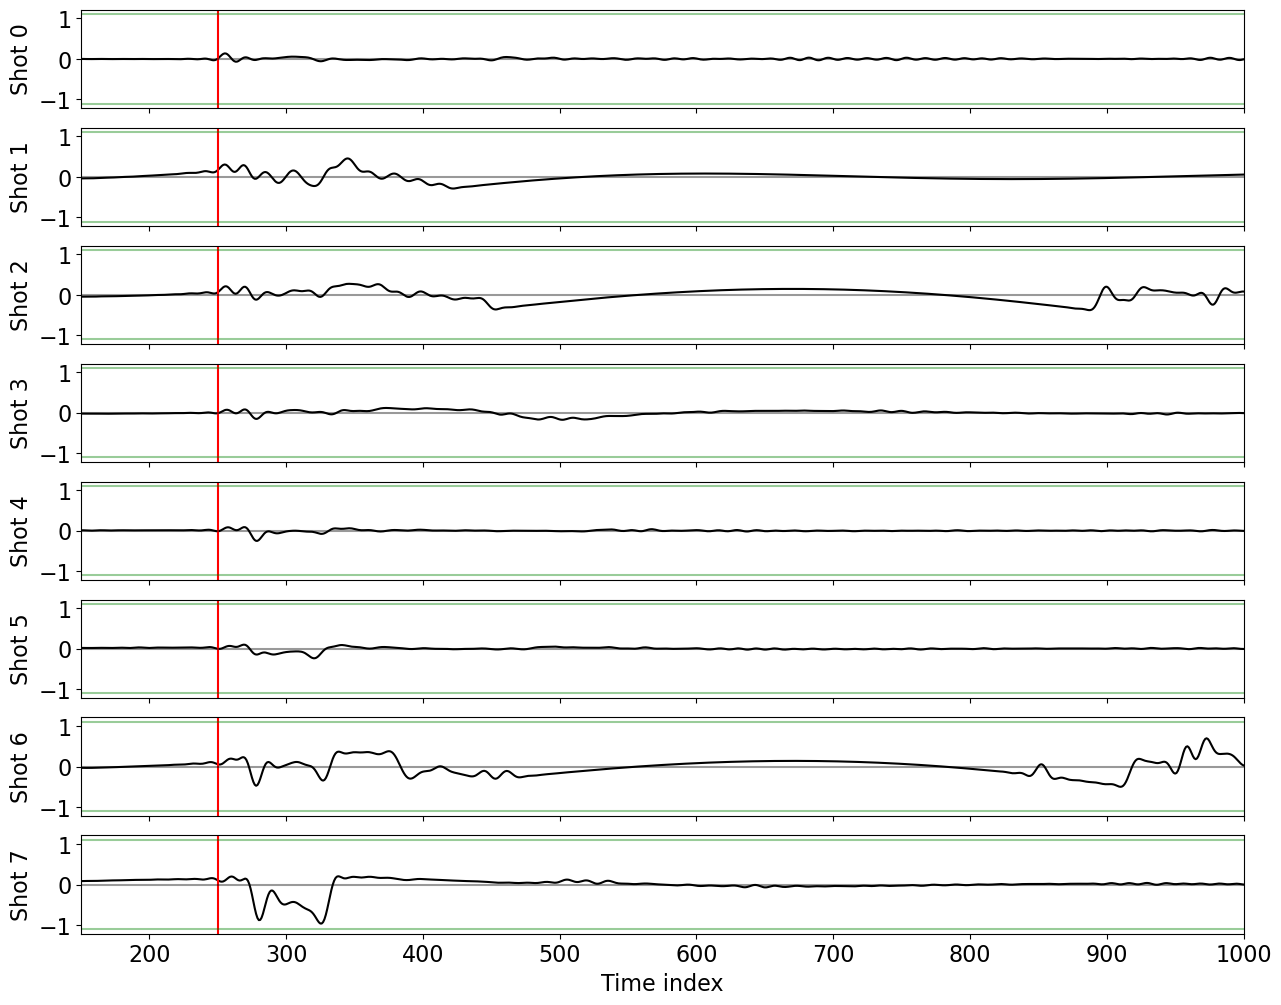

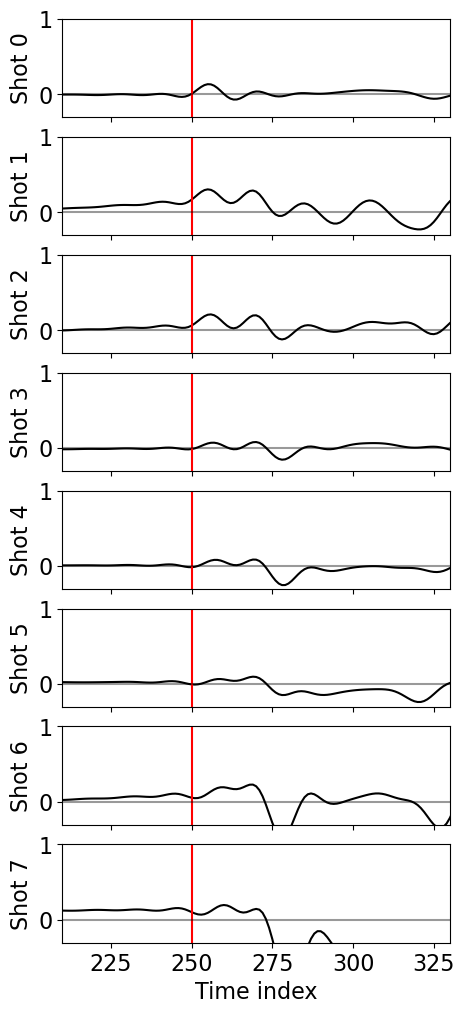

In [113]:
# Filter source trace
signaturefilt = filterdata(7, 2, 80, fs.dt, datashift[:, -1])[-1]

plt.figure(figsize=(15,2))
plt.plot(signaturefilt[:, :1000].ravel(), 'k')
for i in range(datashift.shape[0]): 
    plt.axvline(it0 + i * 1000, c='r')

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(signaturefilt[i].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 4000)

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(signaturefilt[i].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 1000)

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(5, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(signaturefilt[i].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
    axs[i].set_ylim(-0.3, 1.)
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-40, it0+80);

In [114]:
datashift.shape

(8, 90, 6000)